# Modelos lineales

In [1]:
import sys
sys.path.insert(0, '..')
from utils.preprocesamiento import StemmerTokenizer, df_to_list, process_df, procesar_adela
from utils.cargar import df_caso
import pandas as pd

tokenizador = StemmerTokenizer(stem=False,rmv_punctuation=True,)

caso = 'adela'
df = df_caso(caso)
df = procesar_adela(df)
df = df[df['opt_left'] == 'Producir el alimento contra déficit vitamínico']
df = process_df(df,'comment','sel',verbose=False)
df = df.drop(columns=['user_id','team_id','gender','df','title','opt_left','opt_right','max_num','phase','time','curso'])

train_indices = pd.read_csv('../utils/splits/train_indices_{}'.format(caso), header=None)[0].tolist()
test_indices = pd.read_csv('../utils/splits/test_indices_{}'.format(caso), header=None)[0].tolist()
print("Partición train-test cargada")

df_train = df.iloc[train_indices]
df_test = df.iloc[test_indices]

tokenized_corpus = [tokenizador(document) for document in df_train['comment']]
tokenized_test = [tokenizador(document) for document in df_test['comment']]

Partición train-test cargada


LDA

In [2]:
import gensim
from gensim import corpora

# Create a dictionary from the tokenized corpus
dictionary = corpora.Dictionary(tokenized_corpus)

# Convert the tokenized corpus into a document-term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tokenized_corpus]

In [8]:
sys.path.insert(0, '../topic-modelling/')
from TM_utils import get_lda_embeddings

num_topic = 25

lda_model = gensim.models.LdaModel.load('../topic-modelling/modelos/LDA-{}_{}.gensim'.format(caso,num_topic))
print("Cargando modelo pre-ajustado: '../topic-modelling/modelos/LDA-{}_{}.gensim".format(caso,num_topic))

arr_train_lda = get_lda_embeddings(lda_model,tokenizador,dictionary,df_train,'comment')
arr_test_lda = get_lda_embeddings(lda_model,tokenizador,dictionary,df_test,'comment')

Cargando modelo pre-ajustado: '../topic-modelling/modelos/LDA-adela_25.gensim


BERTopic

In [6]:
from bertopic import BERTopic

BT_model = BERTopic.load("../topic-modelling/modelos/BT-{}.bertopic".format(caso))

output_train = BT_model.transform(df_to_list(df_train,'comment',tokenizador))
output_test = BT_model.transform(df_to_list(df_test,'comment',tokenizador))

## Modelo lineal regularizado

**Clasificación**

In [44]:
from sklearn.linear_model import RidgeClassifier

clf_lda = RidgeClassifier(alpha=1)
clf_lda.fit(arr_train_lda,df_train['sel'])

RidgeClassifier(alpha=1)

In [45]:
clf_bt = RidgeClassifier(alpha=1)
clf_bt.fit(output_train[1],df_train['sel'])

RidgeClassifier(alpha=1)

In [46]:
from sklearn.metrics import classification_report

y_pred_lda = clf_lda.predict(arr_test_lda)
y_pred_bt = clf_bt.predict(output_test[1])

print("Resultados clasificador lineal con tópicos LDA")
print(classification_report(df_test['sel'], y_pred_lda))
print("\nResultados clasificador lineal con tópicos BERTopic")
print(classification_report(df_test['sel'], y_pred_bt))

Resultados clasificador lineal con tópicos LDA
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       125
           2       0.34      0.41      0.38       292
           3       0.28      0.65      0.39       347
           4       0.00      0.00      0.00       205
           5       0.00      0.00      0.00       139
           6       0.00      0.00      0.00        46

    accuracy                           0.30      1154
   macro avg       0.10      0.18      0.13      1154
weighted avg       0.17      0.30      0.21      1154


Resultados clasificador lineal con tópicos BERTopic
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       125
           2       0.22      0.01      0.01       292
           3       0.30      0.94      0.46       347
           4       0.22      0.07      0.10       205
           5       1.00      0.01      0.01       139
           6       0.00      0.0

Clasificación Binaria

In [17]:
df_bin = df.copy()

df_bin.loc[(df_bin['sel']==2) | (df_bin['sel']==3),'sel'] = 1
df_bin.loc[(df_bin['sel']==4) | (df_bin['sel']==5),'sel'] = 6

df_train_bin = df_bin.iloc[train_indices]
df_test_bin = df_bin.iloc[test_indices]

df_bin['sel'].value_counts()

sel
1    3813
6    1948
Name: count, dtype: int64

In [19]:
clf_lda = RidgeClassifier(alpha=1.0)
clf_lda.fit(arr_train_lda,df_train_bin['sel'])

clf_bt = RidgeClassifier(alpha=1.0)
clf_bt.fit(output_train[1],df_train_bin['sel']);

In [21]:
y_pred_lda = clf_lda.predict(arr_test_lda)
y_pred_bt = clf_bt.predict(output_test[1])

print("Resultados clasificador lineal con tópicos LDA")
print(classification_report(df_test_bin['sel'], y_pred_lda))
print("\nResultados clasificador lineal con tópicos BERTopic")
print(classification_report(df_test_bin['sel'], y_pred_bt))

Resultados clasificador lineal con tópicos LDA
              precision    recall  f1-score   support

           1       0.66      1.00      0.80       764
           6       0.00      0.00      0.00       390

    accuracy                           0.66      1154
   macro avg       0.33      0.50      0.40      1154
weighted avg       0.44      0.66      0.53      1154


Resultados clasificador lineal con tópicos BERTopic
              precision    recall  f1-score   support

           1       0.66      0.95      0.78       764
           6       0.38      0.06      0.11       390

    accuracy                           0.65      1154
   macro avg       0.52      0.51      0.45      1154
weighted avg       0.57      0.65      0.55      1154



## Regresión con vectorizador Bag-of-Words

In [2]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from utils.preprocesamiento import make_BoW_preprocess, StemmerTokenizer

In [3]:
tokenizer = StemmerTokenizer(stem=False,rmv_punctuation=True,)
preprocessing = make_BoW_preprocess(tokenizer,'comment',max_ngram=2)

bog_pipeline = Pipeline(
    [("Preprocessing", preprocessing),
    #  ("Selection", SelectPercentile(f_classif, percentile=90)),
    ("Clasificador", Ridge())]
)

In [4]:
bog_pipeline.fit(df_train,df_train['sel'])

/home/camilo/miniconda3/envs/ethics_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('bag-of-words',
                                                  CountVectorizer(ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<utils.preprocesamiento.StemmerTokenizer object at 0x7f31b842a340>),
                                                  'comment')])),
                ('Clasificador', Ridge())])

In [5]:
import numpy as np

def reg_to_clf_output(reg_output):
    clf_output = np.round(reg_output).astype(int)
    clf_output = np.where(clf_output < 1, 1, clf_output)
    clf_output = np.where(clf_output > 6, 6, clf_output)
    return clf_output

In [6]:
from sklearn.metrics import classification_report

y_pred = bog_pipeline.predict(df_test)
clf_y_pred = reg_to_clf_output(y_pred)

print("Resultados modelo Regresión lineal (BoW) como clasificador")
print(classification_report(df_test['sel'], clf_y_pred))

Resultados modelo Regresión lineal (BoW) como clasificador
              precision    recall  f1-score   support

           1       0.47      0.30      0.36       125
           2       0.48      0.44      0.46       292
           3       0.41      0.52      0.46       347
           4       0.34      0.46      0.39       205
           5       0.42      0.22      0.29       139
           6       0.37      0.15      0.22        46

    accuracy                           0.42      1154
   macro avg       0.42      0.35      0.36      1154
weighted avg       0.42      0.42      0.41      1154



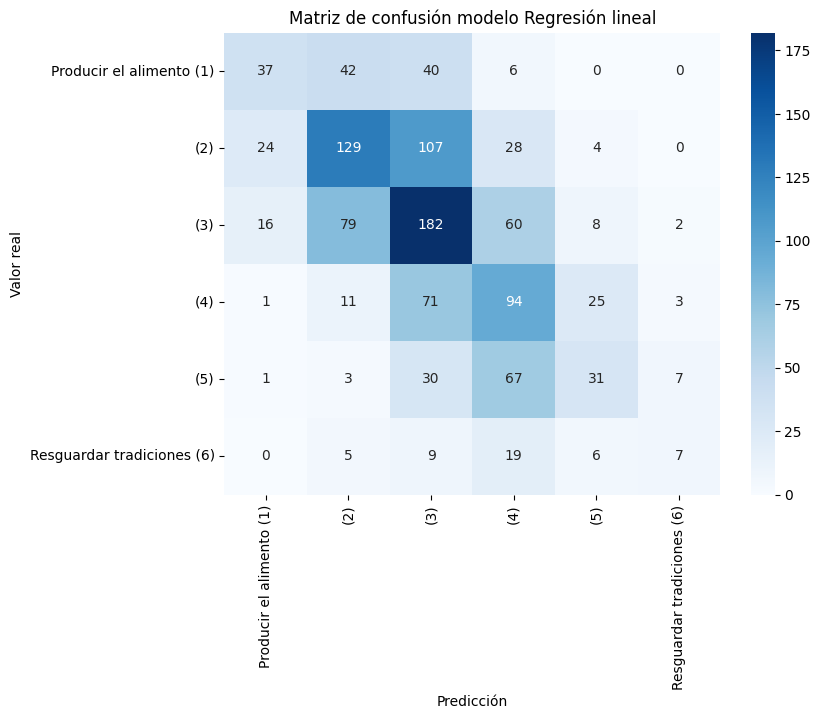

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(df_test['sel'], clf_y_pred)

# Example class labels
class_labels = ['Producir el alimento (1)', '(2)', '(3)', '(4)', '(5)', 'Resguardar tradiciones (6)']

# Convert confusion matrix to NumPy array
cm_array = np.array(cm)

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_array, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)

# Set labels and title
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión modelo Regresión lineal')

# Show the plot
plt.show()

In [8]:
df_bin = df.copy()

df_bin.loc[(df_bin['sel']==2) | (df_bin['sel']==3),'sel'] = 1
df_bin.loc[(df_bin['sel']==4) | (df_bin['sel']==5),'sel'] = 6

# df_train_bin = df_bin.iloc[train_indices]
df_test_bin = df_bin.iloc[test_indices]

In [9]:
clf_y_pred = np.where(clf_y_pred > 3.5, 6, clf_y_pred)
clf_y_pred = np.where(clf_y_pred < 3.5, 1, clf_y_pred)

print("Resultados modelo Regresión lineal como clasificación binaria")
print(classification_report(df_test_bin['sel'], clf_y_pred))

Resultados modelo Regresión lineal como clasificación binaria
              precision    recall  f1-score   support

           1       0.83      0.86      0.85       764
           6       0.71      0.66      0.68       390

    accuracy                           0.79      1154
   macro avg       0.77      0.76      0.77      1154
weighted avg       0.79      0.79      0.79      1154



Resultados similares a Naive-Bayes